In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from fractions import Fraction

In [2]:
def convert_to_fraction(number):
    """Get a fraction of integers to avoid floating points precision error
    when generating an array with np.arange().

    Args:
        number (int/float)

    Returns:
        numerator, denominator (int tuple): 
    """
    if isinstance(number, int):
        return (number, 1)
    frac = Fraction('{0:.16f}'.format(number))
    return (frac.numerator, frac.denominator)

In [3]:
def get_time_array(start, end, time_step):
    """Get a time_array.

    Args:
        start (int/float)
        end (int/float)
        time_step (int/float): max 16 decimal digits

    Returns:
       time_array (ndarray)

    Raises:
       warning if time_step has 12 decimal digits (or more)
       ValueError if precision mismatch time_step vs. start/end
    """
    dt, t_dilation = convert_to_fraction(time_step)

    if t_dilation > 1e12:
        print("WARNING: Ensure that step is not an irrational number")

    t0 = float(start*t_dilation)
    tf = float(end*t_dilation)

    if not tf.is_integer() or not t0.is_integer():
        raise ValueError("START and END time should have less decimals than time_step'")
    
    return np.arange(t0, tf+dt, dt) / t_dilation

In [4]:
# defining step function
def step(delay=0, val=1):
    """Generate a step function 

    Args:
        delay (int/float): starting time of step function
        val(int/float): value of step function

    Returns:
       function
    """

    def step_function(t):
        """Step function

        Args:
            t (number / ndarray)

        Returns
            value of step function at t (scalar / ndarray)
        """
        return val * (t >= delay)

    return step_function

In [5]:
# defining ramp function
def ramp(delay=0, slope=1):
    """Generate a ramp function 

    Args:
        delay (int/float): starting time of step function
        val(int/float): value of step function

    Returns:
       function
    """

    def ramp_function(t):
        """Ramp function

        Args:
            t (number / ndarray)

        Returns
            value of ramp function at t (scalar / ndarray)
        """
        return (t >= delay)*slope*(t-delay)

    return ramp_function

In [6]:
def piecewise(funcs):
    """Generate a single function out of multiple functions

    Args:
        functions: should accept both scallar and ndarrays as parameters

    Returns:
       function
    """
    def wrapper(t):
        return np.array(sum(f(t) for f in funcs))

    return wrapper

In [7]:
def get_stock(t_array, stock_ini=0, netflow=lambda x:0, method='euler'):
    """Integrate netflow over t_array with initial value stock_ini.

    Args:
        t_array (ndarray)
        stock_ini (int / ndarray)
        netflow: function with time and stock as parameter
        method:
            - 'euler': for fast result (will use odeint)
            - 'RK45', 'RK23', 'DOP853' for non-stiff problems (use solve_ivp)
            - 'Radau', 'BDF' for stiff problem (use solve_ivp)

    Returns:
       ndarray
    """
    
    if method == 'euler':

        def eq_diff1(stock, t):
            dStock_dt = netflow(t, stock)
            return dStock_dt
        Stock = odeint(eq_diff1, stock_ini, t_array)
        return np.squeeze(Stock.T)   # result of odeint = transpose of result with solve_ivp


    def eq_diff2(t, stock):
        dStock_dt = netflow(t, stock)
        return dStock_dt
    
    Stock = solve_ivp(eq_diff2,
                      [t_array[0], t_array[-1]],
                      np.atleast_1d(stock_ini),  # solve_ivp requires ndarray as y0
                      method=method,
                      t_eval=t_array,
                      rtol=1e-6).y      # error tolerance (default= 1e-3 can diverge with RK45)
                    
    return np.squeeze(Stock)

In [8]:
def display_stock_vs_flow(time_array, stock, netflow):
    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.plot(time_array, netflow, color='#ff7f0e', label='Net flow')
    ax2 = ax1.twinx()
    ax2.plot(time_array, stock, lw=3, label='Stock')
    
    ax1.set_xlabel('time')
    ax1.set_ylabel('Net Flows', color='#ff7f0e')
    ax2.set_ylabel('Stock', color='royalblue')
   
    ax1.grid(True, axis='both', alpha=0.7)
    ax1.axhline(y=0, color='k')

    fig.legend(loc="upper center")
    plt.show()

In [9]:
def display_stocks(time_array, stocks):
    fig, ax1 = plt.subplots(figsize=(15,5))

    for Stock in stocks:
        ax1.plot(time_array, Stock, lw=3)

    ax1.set_xlabel('time')  
    ax1.grid(True, axis='both', alpha=0.7)
    #fig.legend(loc="best")
    plt.show()

<hr>
&nbsp;

## Example 1

![Population](./attachments/SD-2.0.png)

&nbsp;

$$\frac{dPopulation(t)}{dt} = births(t) - deaths(t)$$

&nbsp;

- 500 skunks live in the wooded grassy area near the highway
- Every year 100 baby skunks are born.
- Every year 120 skunks die from the cars

**Question:** How many skunks will live near the highway in 10 years?

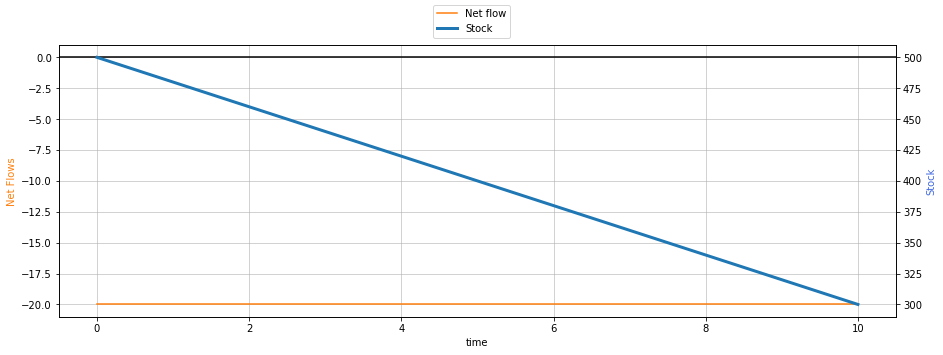

In [10]:
# time array
tm = get_time_array(start=0, end=10, time_step=0.08)  # units: year (0.08 year +/- 1 month)


# Parameters
births = 100   # units: skunks/year
deaths = 120   # units: skunks/year


# Flows equation
def get_netflow(t, population):
    delta = births - deaths
    flow = step(delay=0, val=delta)
    return flow(t)


# Stocks & Netflow
Population = get_stock(t_array=tm, stock_ini=500, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Population)


# Show result
display_stock_vs_flow(tm, Population, Netflow)

<hr>
&nbsp;


## Example 2

![Landfill](./attachments/SD-2.1.png)

&nbsp;

$$\frac{dPlastics(t)}{dt} = dumping(t)$$


&nbsp;

- The city is building a new landfill.
- The trash in the landfill can be separated into 2 categories
    - the trash that will quickly decompose
    - the trash that will take a long time to decompose, like plastics. 
- The city council predicts that the citizens will be dumping 2 tons of plastics every day.


**Question:** How large will the landfill will be in 20 years?

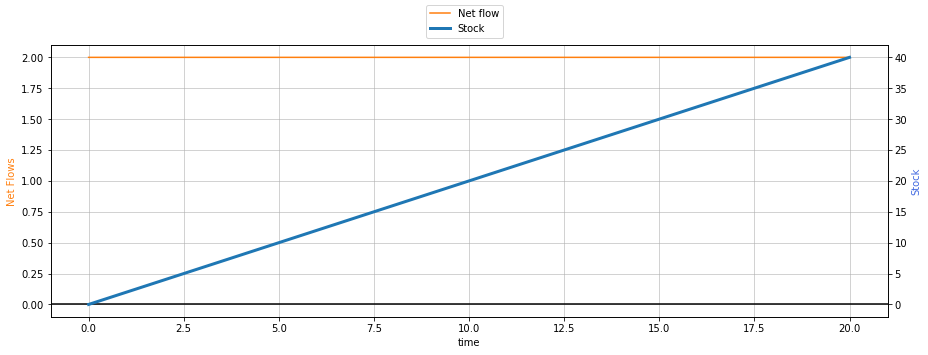

In [11]:
# time array
tm = get_time_array(start=0, end=20, time_step=0.002)  # time unit: years (0.002 year = +/- 1 day)


# Parameters
dumping = 2   # units: tons/year


# Flows equation
def get_netflow(t, plastics):
    flow = step(delay=0, val=dumping)
    return flow(t)


# Stocks & Netflow
Plastics = get_stock(t_array=tm, stock_ini=0, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Plastics)


# Show result
display_stock_vs_flow(tm, Plastics, Netflow)


<hr>
&nbsp;


## Example 3

![Trees](./attachments/SD-2.3.png)

&nbsp;

$$\frac{dTrees(t)}{dt} = planting(t) - harvesting(t)$$


&nbsp;

- Today, there are about 5,000,000 trees in the Hardwood Forest
- A lumber company has been cutting down and harvesting approximately 100,000 trees/year.
- a NGO worried that the forest will be entirely destroyed, has planted approximately 5,000 trees/year

**Question:** How many trees will there be in Hardwood Forest in 30 years?

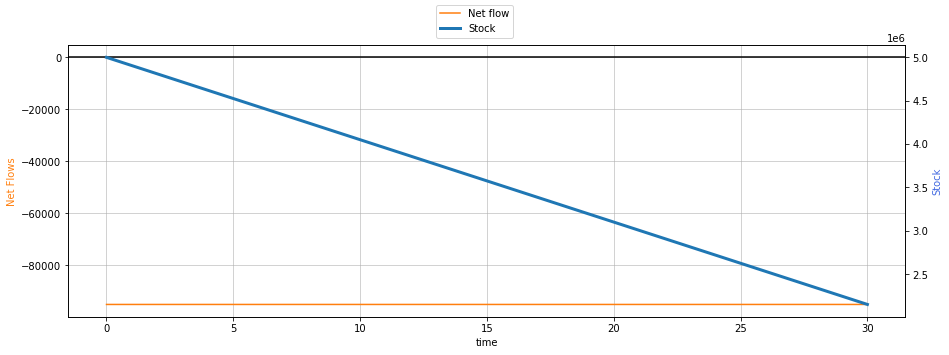

In [12]:
# time array
tm = get_time_array(start=0, end=30, time_step=0.002)  # time unit: years (0.002 year = +/- 1 day)


# Parameters
planting = 5_000       # units: trees/year
harvesting = 100_000   # units: trees/year


# Flows equation
def get_netflow(t, trees):
    inflow = step(delay=0, val=planting)
    outflow = step(delay=0, val=harvesting)
    return inflow(t) - outflow(t)


# Stocks & Netflow
Trees = get_stock(t_array=tm, stock_ini=5_000_000, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Trees)


# Show result
display_stock_vs_flow(tm, Trees, Netflow)

<hr>
&nbsp;

## Generalisation

The following representations are equivalents:

&nbsp;

![Stock Flow analogy](./attachments/SD_analogy.png)

&nbsp;

![Stock Flow SD](./attachments/SD_0.png)

&nbsp;

$$\frac{dStock(t)}{dt} = \color{royalblue}{\text{inflow}(t)} - \color{orangered}{\text{outflow}(t)}$$

&nbsp;

$$Stock(t) = \int_{0}^t [\color{royalblue}{\text{inflow}(t)} - \color{orangered}{\text{outflow}(t)}]dt + Stock(0)$$

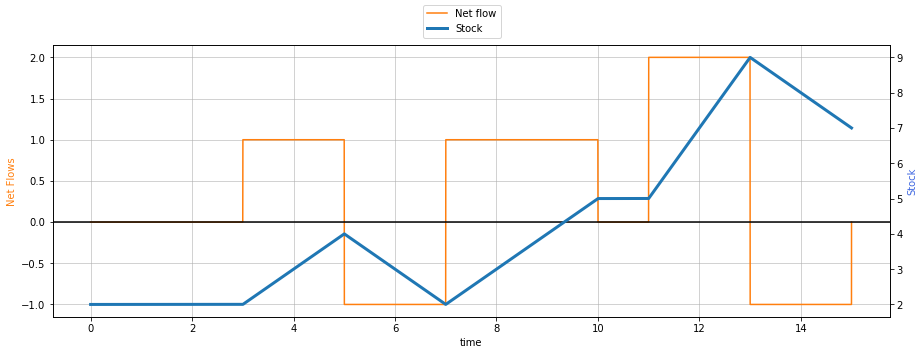

In [13]:
# time array
tm = get_time_array(start=0, end=15, time_step=0.001)


# Flows equation
def get_netflow(t, Stock):
    functions = [step(3,1), step(5,-2), step(7,2), step(10,-1),
                step(11,2), step(13,-3), step(15,1)]
    netflow = piecewise(functions)
    return netflow(t)


# Stocks & Netflow
Stock = get_stock(t_array=tm, stock_ini=2, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Stock)


# Show result
display_stock_vs_flow(tm, Stock, Netflow)


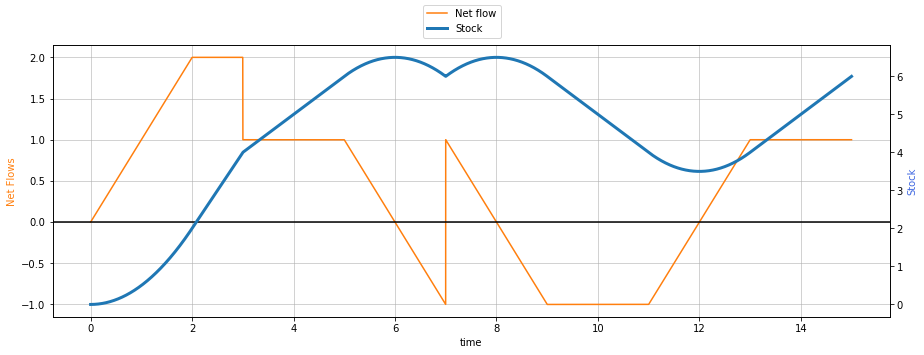

In [14]:
# time array
tm = get_time_array(start=0, end=15, time_step=0.001)


# Flows equation
def get_netflow(t, Stock):
    functions = [ramp(0,1), ramp(2,-1), step(3,-1), ramp(5,-1),
                step(7,2), ramp(9,1), ramp(11,1), ramp(13,-1)]
    netflow = piecewise(functions)
    return netflow(t)


# Stocks & Netflow
Stock = get_stock(t_array=tm, stock_ini=0, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Stock)


# Show result
display_stock_vs_flow(tm, Stock, Netflow)

<hr>
&nbsp;

## Feedback

[Bacteria reproduction]()

Now the flows depends on the stock. 
A feedback loop is a chain of circular causal links, where the level of a stock
influences a flow, which in turn will change the stock

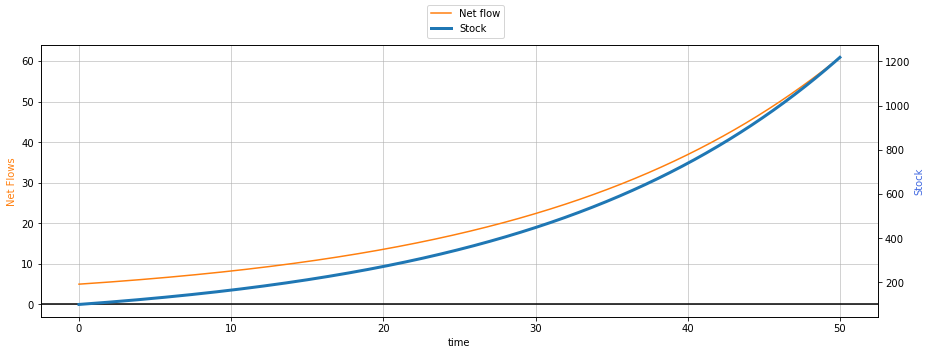

In [15]:
# time array
tm = get_time_array(start=0, end=50, time_step=0.01)


# Parameters
reproduction_fraction = 0.05


# Flow equation
def get_netflow(t, bacteria):
    return reproduction_fraction * bacteria


# Stocks & Netflow
Bacteria = get_stock(t_array=tm, stock_ini=100, netflow=get_netflow, method='RK45')
Netflow = get_netflow(tm, Bacteria)


# Show result
display_stock_vs_flow(tm, Bacteria, Netflow)

[Customer Stock & Flow image]()

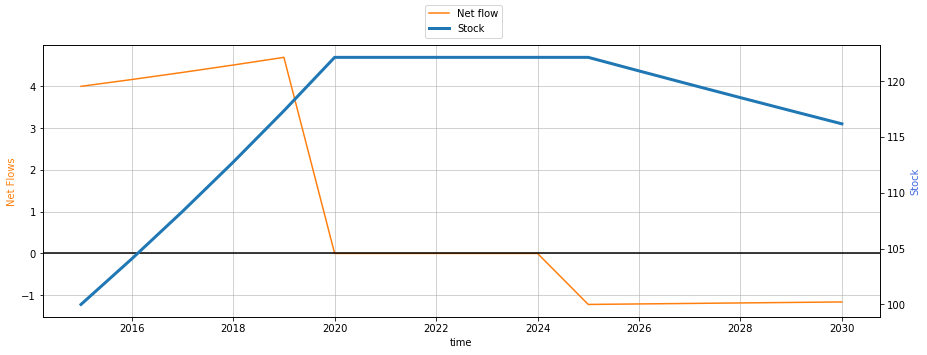

In [16]:
# time array
tm = get_time_array(start=2015, end=2030, time_step=1)


# Parameters
growth_fraction = piecewise([step(0, 0.07), 
                             step(2020, -0.04),
                             step(2025, -0.01)])
decline_fraction = 0.03


# Flow equation
def get_netflow(t, customers):
    Recruits = customers*growth_fraction(t)
    Losses = customers*decline_fraction
    return Recruits - Losses


# Stocks & Netflow
Customers = get_stock(t_array=tm, stock_ini=100, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Customers)


# Show result
display_stock_vs_flow(tm, Customers, Netflow)

[S shaped growth Stock & Flow example]()

$$\frac{dP}{dt} = rP\left(1 - \frac{P}{K}\right)$$

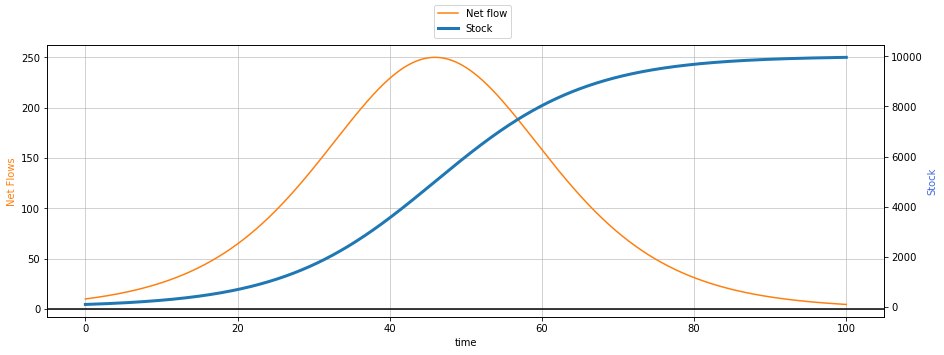

In [17]:
# time array
tm = get_time_array(start=0, end=100, time_step=0.02)


# Parameters
capacity = 10000
ref_availability = 1
ref_growth_rate = 0.10


# Flow equation
def get_netflow(t, population):
    availability = 1 - population/capacity
    effect_availability = availability/ref_availability
    growth_rate = ref_growth_rate * effect_availability
    return population*growth_rate


# Stocks & Netflow
Population = get_stock(t_array=tm, stock_ini=100, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Population)


# Results
display_stock_vs_flow(tm, Population, Netflow)

[Model of Economic Growth]


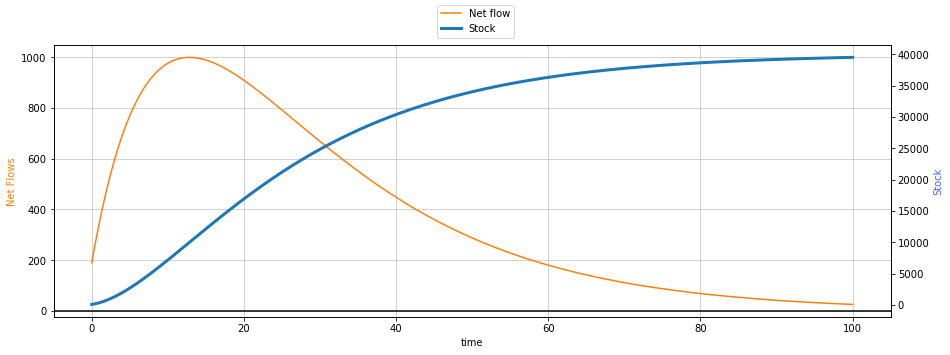

In [18]:
# time array
tm = get_time_array(start=0, end=100, time_step=0.02)


# Parameters
reinvestment_fraction = 0.2
depreciation_fraction = 0.1
labour = 100


# Flow equation
def get_netflow(t, machines):
    economic_output = 100*np.sqrt(machines)
    investment = economic_output*reinvestment_fraction
    discards = machines*depreciation_fraction
    return investment - discards


# Stocks & Netflow
Machines = get_stock(t_array=tm, stock_ini=100, netflow=get_netflow, method='euler')
Netflow = get_netflow(tm, Machines)


# Results
display_stock_vs_flow(tm, Machines, Netflow)

Model of economic growth with non renewable stock constraint

duggan

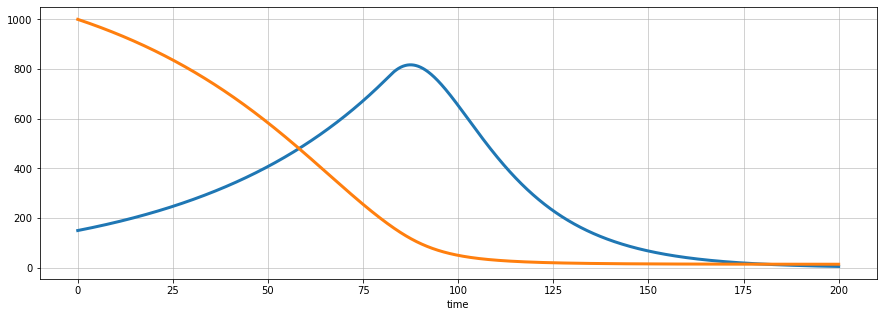

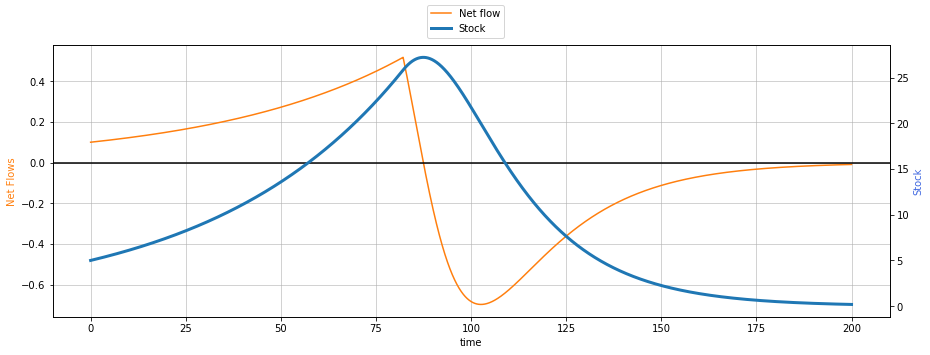

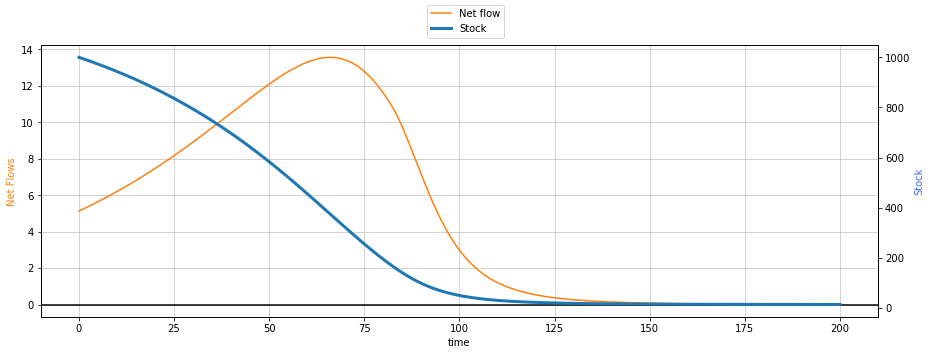

In [19]:
# time array
tm = get_time_array(start=0, end=200, time_step=0.01)

# Parameters
depreciation_rate = 0.05
desired_growth_fraction = 0.07
revenue_per_unit_extracted = 3
fraction_profits_reinvested = 0.12
cost_per_investment = 2

def extraction_efficiency(x):
    return -1.096*np.exp(-0.003*x)+1.08

# Flow equation
def get_netflow(t, x):
    capital = x[0]
    resource = x[1]
    depreciation = capital*depreciation_rate
    extraction = capital*extraction_efficiency(resource)
    total_revenue = extraction*revenue_per_unit_extracted   
    capital_costs = capital*0.1
    profit = total_revenue - capital_costs
    capital_funds = profit*fraction_profits_reinvested
    desired_investment = capital*desired_growth_fraction
    max_investment = capital_funds/cost_per_investment
    investment = np.minimum(max_investment, desired_investment)
    dCapital_dt = investment - depreciation
    dResource_dt = -extraction
    return [dCapital_dt, dResource_dt]

# Stocks & Netflow
Capital, Resource = get_stock(t_array=tm, stock_ini=[5, 1000], netflow=get_netflow, method='euler')
Netflow_cap, Netflow_res = get_netflow(tm,  [Capital, Resource])
Extraction = -Netflow_res

# Results
display_stocks(tm, [30*Capital, Resource])
display_stock_vs_flow(tm, Capital, Netflow_cap)
display_stock_vs_flow(tm, Resource, Extraction)


In [20]:
Peak_Value = '{0:.2f}'.format(np.max(Extraction))
Peak_time = tm[np.argmax(Extraction)]
print(f'Peak value: {Peak_Value} at t = {Peak_time}')

Peak value: 13.56 at t = 66.02


Insect outbreak Strogatz / Ludwig et al. (1978)

$$\frac{dN}{dt} = RN\left(1 - \frac{N}{K}\right) - p(N)$$

with
$$p(N) = \frac{BN^2}{A^2 + N^2}$$

  
  
### Reformulating the equations in a dimensionless form

$x = \frac{N}{A}$ leads to:
$$\frac{A}{B} \frac{dN}{dt}  = \frac{R}{B}Ax \left(1 - \frac{Ax}{K}\right) - \frac{x^2}{1+x^2} $$

$\tau = \frac{Bt}{A}$, $r = \frac{RA}{B}$, $\kappa = \frac{K}{A}$ leads to
$$\frac{dx}{d\tau}  = rx \left(1 - \frac{x}{\kappa}\right) - \frac{x^2}{1+x^2} $$



### Analysis of fixed points $\frac{dx^*}{d\tau} = 0$

$$x^* = 0 \text{  or  } r \left(1 - \frac{x^*}{\kappa}\right) = \frac{x^*}{1+x^{*2}} $$

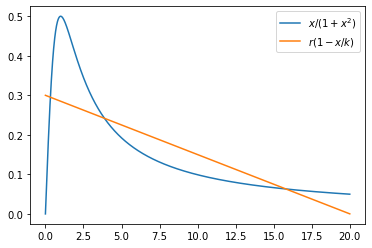

In [33]:
r, k = 0.3, 20
x= np.arange(0, 20, 0.01) 


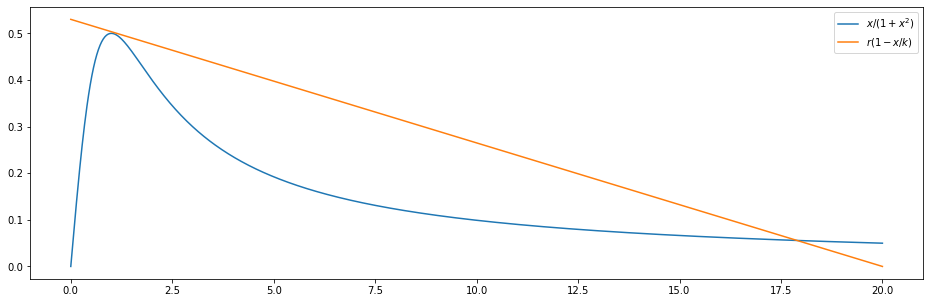

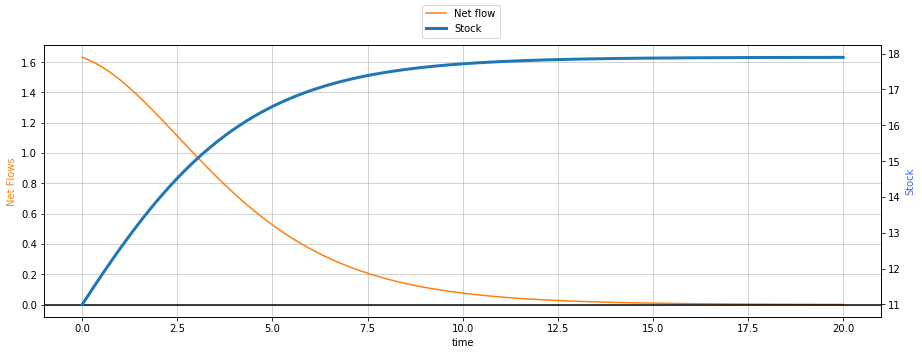

In [63]:
# time array
x = get_time_array(start=0, end=20, time_step=0.02)


# Parameters
r = 0.53
k = 20


# Flow equation
def get_netflow(t, x):
    z = np.power(x, 2)
    dx_dt = r*(x-z/k)-z/(1+z)
    return dx_dt


# Stocks & Netflow
Insects = get_stock(t_array=x, stock_ini=11, netflow=get_netflow, method='euler')
Netflow = get_netflow(x, Insects)


# Results
plt.figure(figsize=(16,5))
plt.plot(x, x/(1+x**2), label='$x/(1+x^2)$')
plt.plot(x, r*(1-x/k), label='$r(1-x/k)$')
plt.legend(loc='best')
plt.show()

display_stock_vs_flow(x, Insects, Netflow)

<hr>

## Example 8: Predators-Preys

(also known as [Lotka–Volterra equations](https://www.wikiwand.com/en/Lotka%E2%80%93Volterra_equations))

&nbsp;

$$\frac{dx_1}{dt} =  \color{royalblue}{\alpha} x_1  \color{orangered}{- \beta x_2}x_1$$

$$\frac{dx_2}{dt}  =  \color{royalblue}{\delta x_1}x_2 \color{orangered}{- \gamma}x_2$$


&nbsp;  
**with:**
- $\color{royalblue}{\text{inflow}}$
- $\color{orangered}{\text{outflow}}$


&nbsp;
**Stocks:**
- $x_1$: sheep
- $x_2$: wolves


&nbsp;
**Flows:**
- $\dot{x}_1$: sheep flows (births - deaths)
    - $\alpha$: sheep birth rate
    - $\beta$: predation rate
- $\dot{x}_2$: wolves flows (births - deaths)
    - $\delta$: predator efficiency
    - $\gamma$: wolf death rate

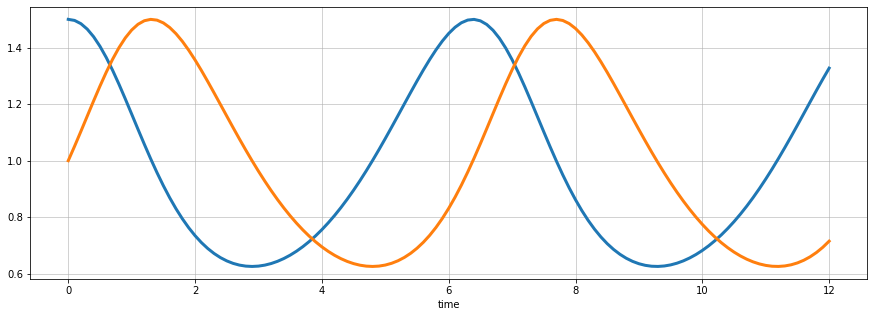

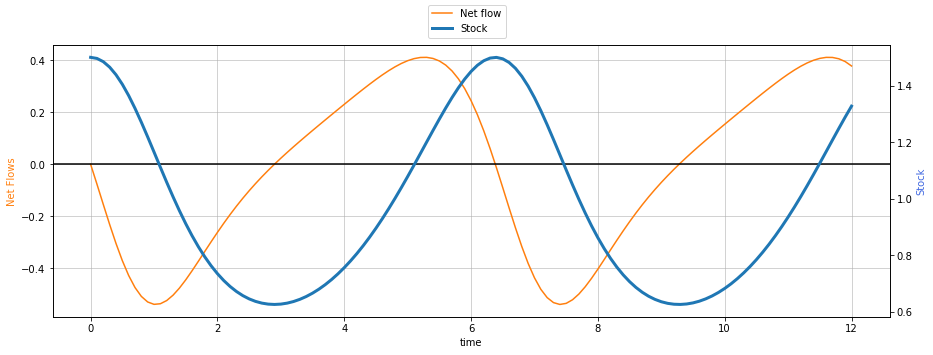

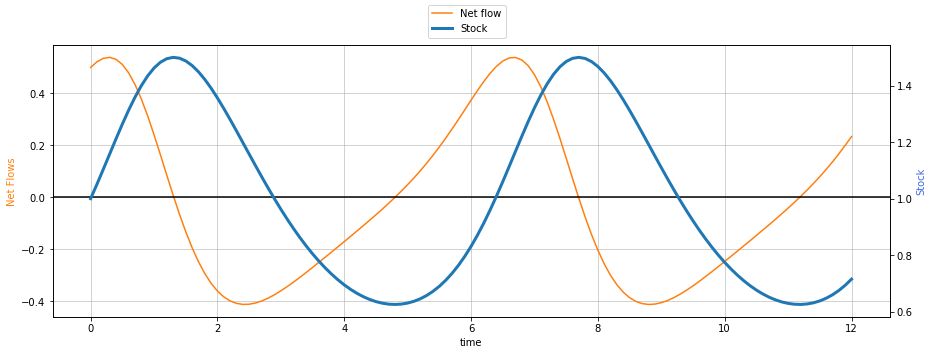

In [75]:
# time array
tm = get_time_array(start=0, end=12, time_step=0.1)

# Parameters
sheep_birth_rate = 1
predation_rate = 1
predator_efficiency = 1
wolf_death_rate = 1

# Flow equation
def get_netflow(t, x):
    sheep = x[0]
    wolves = x[1]
    dsheep_dt = sheep*(sheep_birth_rate - predation_rate*wolves)
    dwolves_dt = wolves*(predator_efficiency*predation_rate*sheep - wolf_death_rate)
    return [dsheep_dt, dwolves_dt]

# Stocks & Netflow
Sheep, Wolves = get_stock(t_array=tm, stock_ini=[1.5, 1], netflow=get_netflow, method='euler')
Netflow_sheep, Netflow_wolves = get_netflow(tm, [Sheep, Wolves])

# Results
display_stocks(tm, [Sheep, Wolves])
display_stock_vs_flow(tm, Sheep, Netflow_sheep)
display_stock_vs_flow(tm, Wolves, Netflow_wolves)

<hr>

## Example 9

&nbsp;

$$\frac{dx_1}{dt} = \color{royalblue}{a}x_1 \color{orangered}{- b x_2}x_1$$

$$\frac{dx_2}{dt} =  \color{royalblue}{c x_1} x_2 \color{orangered}{- d x_3} x_2$$

$$\frac{dx_3}{dt} = \color{royalblue}{e x_2} x_3  \color{orangered}{- f} x_3 $$



&nbsp;  
**with:**
- $\color{royalblue}{\text{inflow}}$
- $\color{orangered}{\text{outflow}}$


&nbsp;
**Stocks:**
- $x_1$: Vegetation
- $x_2$: Preys
- $x_3$: Predators


&nbsp;
**Flows:**

- $\frac{dx_1}{dt} $: Vegetation flows (regeneration - deaths)
    - $\color{royalblue}{a}$: external_seed_dispersion_rate * seed_survival_probability * frac_veg_regen_rate
    - $\color{orangered}{b}$: prey_search_efficiency

- $\frac{dx_2}{dt} $: Prey flows (births - deaths)
    - $\color{royalblue}{c}$: prey_search_efficiency * prey_food_conversion_efficiency
    - $\color{orangered}{d}$: pred_search_efficiency

- $\frac{dx_3}{dt} $: Predators flows (births - deaths)
    - $\color{royalblue}{e}$: pred_search_efficiency * pred_food_conversion_efficiency
    - $\color{orangered}{f}$: frac_pred_death_rate



&nbsp;

![vegeration preys and predators](./veg_prey_pred.png)


In [ ]:
# parameters
external_seed_dispersion_rate = 300      # Units: veg/month
seed_survival_probability = 0.25         # Units: dmnl
frac_veg_regen_rate = 0.25               # Units: 1/month
min_veg_popul = 2                        # Units: veg
min_veg_death_time = 1                   # Units: 1/month

prey_search_efficiency = 0.2             # Units: 1/prey/month
prey_food_conversion_efficiency = 0.005  # Units: prey/veg
min_prey_popul = 2                       # Units: prey
min_prey_death_time = 1                  # Units: 1/month


pred_search_efficiency = 0.02            # Units: 1/pred/month
pred_food_conversion_efficiency = 0.1    # Units: pred/prey
min_pred_popul = 0                       # Units: pred
min_pred_death_time = 1                  # Units: 1/month
frac_pred_death_rate = 0.1               # Units: 1/month


# Initial values
Vegetation_ini = 100_000
Preys_ini = 500
Predators_ini = 10
x0 = [Vegetation_ini, Preys_ini, Predators_ini]

# Time horizon
t = np.linspace(0, 1500, 20_000)

In [ ]:
def veg_prey_pred(x, t):
    
    Vegetation = x[0]
    Preys = x[1]
    Predators = x[2]

    # dynamic variables
    max_veg_death_rate = 1
    max_prey_death_rate = 1
    max_pred_death_rate = 1

    

    # Flows
    veg_regen_rate = external_seed_dispersion_rate * seed_survival_probability * frac_veg_regen_rate * Vegetation  # Units: veg / month
    veg_death_rate = min(prey_search_efficiency * Preys * Vegetation, max_veg_death_rate)                     # Units: veg / month

    prey_birth_rate = prey_search_efficiency * prey_food_conversion_efficiency * Vegetation * Preys  # Units: prey / month
    prey_death_rate = min(pred_search_efficiency * Predators * Preys, max_prey_death_rate)      # Units: prey / month

    pred_birth_rate = pred_search_efficiency * pred_food_conversion_efficiency * Preys * Predators  # Units: pred / month
    pred_death_rate = min(frac_pred_death_rate * Predators, max_pred_death_rate)               # Units: pred / month


    # Stocks
    dVegetationdt = veg_regen_rate - veg_death_rate
    dPreysdt = prey_birth_rate - prey_death_rate
    dPredatorsdt = pred_birth_rate - pred_death_rate
    
    return [dVegetationdt, dPreysdt, dPredatorsdt]

In [ ]:
# def veg_prey_pred(x, t):
    
#     Vegetation = x[0]
#     Preys = x[1]
#     Predators = x[2]

#     # dynamic variables
#     max_veg_death_rate = (Vegetation - min_veg_popul)/min_veg_death_time if Vegetation >= min_veg_popul else 0
#     max_prey_death_rate = (Preys - min_prey_popul)/min_prey_death_time if Preys >= min_prey_popul else 0
#     max_pred_death_rate = (Predators - min_pred_popul)/min_pred_death_time if Predators >= min_pred_popul else 0


#     # Flows
#     veg_regen_rate = external_seed_dispersion_rate * seed_survival_probability * frac_veg_regen_rate * Vegetation  # Units: veg / month
#     veg_death_rate = np.min([prey_search_efficiency * Preys * Vegetation, max_veg_death_rate])                     # Units: veg / month

#     prey_birth_rate = prey_search_efficiency * prey_food_conversion_efficiency * Vegetation * Preys  # Units: prey / month
#     prey_death_rate = np.min([pred_search_efficiency * Predators * Preys, max_prey_death_rate])      # Units: prey / month

#     pred_birth_rate = pred_search_efficiency * pred_food_conversion_efficiency * Preys * Predators  # Units: pred / month
#     pred_death_rate = np.min([frac_pred_death_rate * Predators, max_pred_death_rate])               # Units: pred / month


#     # Stocks
#     dVegetationdt = veg_regen_rate - veg_death_rate
#     dPreysdt = prey_birth_rate - prey_death_rate
#     dPredatorsdt = pred_birth_rate - pred_death_rate
    
    
#     return [dVegetationdt, dPreysdt, dPredatorsdt]

In [ ]:
x = odeint(veg_prey_pred, x0, t)

In [ ]:
vegetation = x[:, 0]
preys = x[:, 1]
predators = x[:, 2]

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(t, vegetation, label='vegetation')
plt.plot(t, preys, label='preys')
plt.plot(t, predators, label='predators')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Credits:

Sterner,E.,Adawi,T.,Persson,M.etal(2019)Knowinghowandknowingwhen:unpackingpublicunderstandingofatmosphericCO2accumulationClimaticChange,154(1-2):49-67http://dx.doi.org/10.1007/s10584-019-02423-8